# PROGETTO DIGITAL SIGNAL IMAGE MANAGEMENT

### CLASSIFICAZIONE AUDIO

Cattaneo Andrea, matricola n°815585, a.cattaneo66@campus.unimib.it\
Marinoni Andrea, matricola n°799690, a.marinoni14@campus.unimib.it\
Marzorati Stefano, matricola n°830272, s.marzorati11@campus.unimib.it 

La prima parte del progetto si pone l'obiettivo di effettuare una classificazione di audio.
Il dataset utilizzato per l'addestramento del modello è costituito da una cartella denominata "audio_nostri", contente tre ulteriori sottocartelle, le quali consentono di distinguere le tre diverse classi di appartenenza degli audio in esse racchiusi.  

- **rimbalzino_folder**: classe attribuita agli audio di Andrea Cattaneo  
- **bigmari_folder**: classe attribuita agli audio di Andrea Marinoni  
- **stemanzo_folder**: classe attribuita agli audio di Stefano Marzorati

# CLASSIFICAZIONE AUDIO

## Librerie

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
import os
from shutil import copyfile
import zipfile 
from matplotlib import pyplot as plt
from scipy.io import wavfile as wav
from scipy.fft import rfft, fft, irfft, ifft, fftfreq
from scipy.signal import fftconvolve
from IPython.display import Audio
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import sklearn
# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import layers, models
import sounddevice as sd

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras import optimizers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
!pip install scikeras[tensorflow]
from scikeras.wrappers import KerasClassifier
from pickle import dump, load

La macchina virtuale, colab, viene collegata alla repository di Gdrive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


La cartella desiderata viene importata ed estratta dal file compresso, in modo da utilizzarla durante l'esercizio

In [ ]:
# Transfer zip dataset to the current virtual machine
copyfile('gdrive/My Drive/DSIM_project/audio_nostri.zip', 'audio_nostri.zip')
# Extract files
zip = zipfile.ZipFile('audio_nostri.zip')
zip.extractall()
zip.close()

Viene creata una lista contenente le labels delle 3 classi presenti nel dataset

In [ ]:
FOLDER_NAME = ['rimbalzino_folder', 'bigmari_folder', 'stemanzo_folder']

## Analisi esplorativa

Il dataset è composto da 150 audio suddivisi equamente in 3 classi, quindi 50 audio per ogni partecipante.

Gli audio sono stati creati ad-hoc per il progetto, registrando la voce dei 3 componenti del gruppo, durante una lettura di alcuni articoli di giornale.

La durata degli audio è di 5 secondi  

Viene condotta un analisi preliminare su un audio del dataset per comprenderne la struttura

In [ ]:
audio_rate, audio = wav.read('audio_nostri/rimbalzino_folder/rimbalzino0.wav')

La qualità di un file audio è determinata dal suo rate. Il rate si riferisce alla quantità di dati elaborati al secondo.  
In questo caso per ogni secondo vengono catturati 44100 campioni.

In [ ]:
audio_rate

44100

Come si evince dalla shape della registrazione, ogni audio ha un singolo canale.

In [ ]:
audio.shape

(220500,)

Viene riprodotto l'audio e si visualizza il suo grafico audiometrico

In [ ]:
Audio(audio, rate=audio_rate)

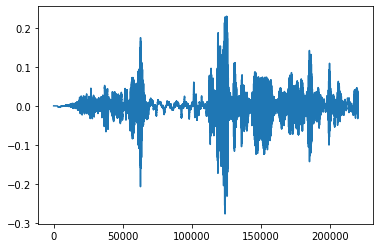

In [ ]:
plt.plot(audio);

## Data Augmentation

La data augmentation è un insieme di tecniche per aumentare artificialmente la quantità di dati generandone di nuovi partendo dai dati esistenti.
Viene utilizzata al fine di migliorare le capacità di generalizzazione del modello e ridurre l'overfitting.

Si è deciso di effettuare la data augmentation attraverso alcune trasformazioni: 

-  **noise_injection**, inserisce del rumore all'interno degli audio, in modo da meglio generalizzarli

-  **shifting_time**, sposta temporalmente l'inizio o la fine dell'audio

-  **changing_pitch**, aumenta o diminuisce la tonalità dell'audio

### Function Augmentation

Vengono costruite delle funzioni di data augmentation da richiamare in seguito

In [ ]:
def noise_injection(data, noise_factor = 0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [ ]:
def shifting_time(data, sampling_rate = audio_rate, shift_max = 1):
    shift = np.random.randint(sampling_rate * shift_max)
    shift = -shift
    augmented_data = np.roll(data, shift)
    augmented_data[shift:] = 0
    return augmented_data

In [ ]:
def changing_pitch(data, sampling_rate = audio_rate, pitch_factor = -1):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

### Data Augmentation

Si richiamano le funzioni di data augmentation costruite precedentemente, applicandole sugli audio da noi registrati e si salvano i nuovi dati aumentati nelle cartelle del dataset.

In [ ]:
RIMBALZINO_FILE = []
BIGMARI_FILE = []
STEMANZO_FILE = []

In [ ]:
def get_file_name(folder_name, list_file):
   for file_name in os.listdir(folder_name):
    if file_name.endswith('.wav'):
      list_file.append(file_name)

In [ ]:
get_file_name("audio_nostri/rimbalzino_folder/", RIMBALZINO_FILE)
get_file_name("audio_nostri/bigmari_folder/", BIGMARI_FILE)
get_file_name("audio_nostri/stemanzo_folder/", STEMANZO_FILE)

In [ ]:
def folder_augmentation(folder_name, file_list, augmentation_function, label):
  for file_name in file_list:
    audio_rate, audio = wav.read(folder_name + file_name)
    audio_augmented = augmentation_function(audio)
    filename = folder_name + file_name[:-4] + '_' + str(label) + '.wav'
    wav.write(filename, rate = audio_rate, data = audio_augmented)   

**noise injection**

In [ ]:
folder_augmentation("audio_nostri/rimbalzino_folder/", RIMBALZINO_FILE, noise_injection, "noise")
folder_augmentation("audio_nostri/bigmari_folder/", BIGMARI_FILE, noise_injection, "noise")
folder_augmentation("audio_nostri/stemanzo_folder/", STEMANZO_FILE, noise_injection, "noise")

**time shifting**

In [ ]:
folder_augmentation("audio_nostri/rimbalzino_folder/", RIMBALZINO_FILE, shifting_time, "shifted")
folder_augmentation("audio_nostri/bigmari_folder/", BIGMARI_FILE, noise_injection, "shifted")
folder_augmentation("audio_nostri/stemanzo_folder/", STEMANZO_FILE, noise_injection, "shifted")

**changing pitch**

In [ ]:
folder_augmentation("audio_nostri/rimbalzino_folder/", RIMBALZINO_FILE, changing_pitch, "pitched")
folder_augmentation("audio_nostri/bigmari_folder/", BIGMARI_FILE, changing_pitch, "pitched")
folder_augmentation("audio_nostri/stemanzo_folder/", STEMANZO_FILE, changing_pitch, "pitched")

## Feature Extraction

Feature Extraction si riferisce al processo di trasformazione dei dati grezzi in caratteristiche numeriche che possono essere elaborate preservando le informazioni nel set di dati originale. 
Serve ad individuare i particolari caratterizzanti del singolo audio.
Esistono diversi tipi di feature extraction, in questo elaborato si useranno:

-  **zcr** : zero crossing rate (ZCR) misura quante volte l'onda audio attraversa l'asse zero.

-  **mfcc** : mel-frequency cepstral coefficients è uno dei feature extractor migliori nell'ambito audio recognition. Le mfcc sono un piccolo insieme di features che descrivono in modo conciso la forma complessiva di un involucro spettrale.

-  **combo** : una funzione che combini lo ZCR e le mfcc.

In [ ]:
def feature_extraction_zcr(audio, audio_rate):
  zcr = librosa.feature.zero_crossing_rate(audio)[0]
  return np.array(zcr)

In [ ]:
def feature_extraction_mfcc(audio, audio_rate):
  mfccs = librosa.feature.mfcc(audio, sr=audio_rate)
  return sklearn.preprocessing.scale(mfccs, axis=1)[0]

In [ ]:
def feature_extraction_combo (audio, audio_rate):
  return np.concatenate((feature_extraction_zcr(audio, audio_rate), feature_extraction_mfcc(audio, audio_rate)), axis = 0)

`load_data` è la funzione che permette di dividere il dataset in train e test set, applicando già la funzione di feature extractor scelta e una normalizzazione.  
Nel nostro caso la divisione in train e test set è stata fatta con le seguenti proporzioni:


*   Train set: 80% del dataset
*   Test set: 20% del dataset





In [ ]:
def load_data(feature_extractor, normalize=False):

    labels = []
    features = []
    for folder in FOLDER_NAME:
      for file in os.listdir('./audio_nostri/' + folder):
        if file.endswith('.wav'):
            # Load file and compute the requested features
            audio_rate, audio = wav.read('./audio_nostri/' + folder+'/'+ file)
            cur_features = feature_extractor(audio, audio_rate)
            features.append(cur_features)

            # Classes
            label = folder.split("_")[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test, X_train_mean, X_train_std

**zcr**

In [ ]:
X_train_zcr, X_test_zcr, y_train_zcr, y_test_zcr, mean_zcr, std_zcr = load_data(feature_extraction_zcr, True)

**mfcc**

In [ ]:
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, mean_mfcc, std_mfcc = load_data(feature_extraction_mfcc, True)

**combo**

In [ ]:
X_train_combo, X_test_combo, y_train_combo, y_test_combo, mean_combo, std_combo = load_data(feature_extraction_combo, True)

## Metodi Machine Learning

Le Support Vector Machine (SVM) sono un insieme di metodi di apprendimento supervisionato utilizzati per la classificazione.

I vantaggi sono:

-  Efficacia in spazi con grande dimensionalità.

-  Utilizza un sottoinsieme di punti di addestramento nella funzione decisionale, diventando efficiente anche in termini di memoria.

- È versatile: è possibile specificare diverse funzioni del kernel. 

Si è deciso di ottimizzare la SVM tramite una grid search, in modo da trovare i parametri più adatti al corrente case study.

In [ ]:
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

In [ ]:
def apply_SVC(param_grid, X_train, X_test, y_train, y_test):
  clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)
  clf = clf.fit(X_train, y_train)
  
  print('\n\n')
  print('Best parameters combination:')
  print(' C: '+str(clf.best_estimator_.C))
  print(' gamma: '+str(clf.best_estimator_.gamma))

  print('\n\n')
  y_pred = clf.predict(X_test)
  print('----------------------------------')
  print('Classification report:')
  print(classification_report(y_test, y_pred))

  print('\n\n')
  print('Confusion matrix:')
  cm = confusion_matrix(y_test, y_pred)
  print(cm)
  print('\n\n')
  plt.imshow(cm, cmap=plt.cm.Blues)

**zcr**

Utilizzando zcr come feature extractor i risultati ottenuti sono discreti, in particolare si registra un'accuracy di 0.8 per le previsioni sul test set.     Inoltre si può notare dalla matrice di confusione e dalla heatmap che la maggior parte delle previsioni risiedono sulla diagonale principale, segno che il modello distingue correttamente le diverse classi.




Best parameters combination:
 C: 100.0
 gamma: 0.01



----------------------------------
Classification report:
              precision    recall  f1-score   support

     bigmari       0.77      0.75      0.76        32
  rimbalzino       0.70      0.90      0.79        41
    stemanzo       0.97      0.74      0.84        47

    accuracy                           0.80       120
   macro avg       0.81      0.80      0.80       120
weighted avg       0.83      0.80      0.80       120




Confusion matrix:
[[24  8  0]
 [ 3 37  1]
 [ 4  8 35]]





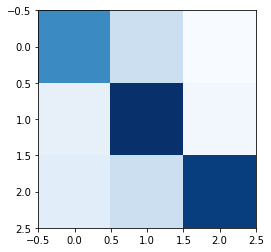

In [ ]:
apply_SVC(param_grid, X_train_zcr, X_test_zcr, y_train_zcr, y_test_zcr)

**mfcc**

Cambiando la funzione di feature extraction e utilizzandone una più efficace nel campo dell'audio come mfcc, si ottengono risultati migliori. Nello specifico l'accuracy raggiunge il valore del 100% in sede di test, classificando correttamente tutti gli audio.




Best parameters combination:
 C: 100.0
 gamma: 0.01



----------------------------------
Classification report:
              precision    recall  f1-score   support

     bigmari       1.00      1.00      1.00        32
  rimbalzino       1.00      1.00      1.00        41
    stemanzo       1.00      1.00      1.00        47

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120




Confusion matrix:
[[32  0  0]
 [ 0 41  0]
 [ 0  0 47]]





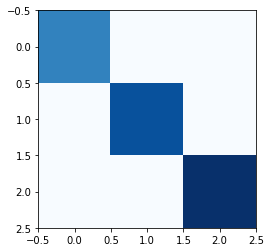

In [ ]:
apply_SVC(param_grid, X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc)

**combo**

Infine sono stati combinati i feature extractor precedenti. Come ci si poteva aspettare questo nuovo feature extractor ha portato a performance peggiori di mfcc, ma comunque migliori dello zcr, registrando in fase di test un'accuracy pari all'82%.




Best parameters combination:
 C: 100.0
 gamma: 0.005



----------------------------------
Classification report:
              precision    recall  f1-score   support

     bigmari       0.96      0.81      0.88        32
  rimbalzino       0.68      0.93      0.78        41
    stemanzo       0.95      0.74      0.83        47

    accuracy                           0.82       120
   macro avg       0.86      0.83      0.83       120
weighted avg       0.86      0.82      0.83       120




Confusion matrix:
[[26  6  0]
 [ 1 38  2]
 [ 0 12 35]]





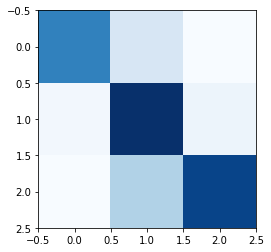

In [ ]:
apply_SVC(param_grid, X_train_combo, X_test_combo, y_train_combo, y_test_combo)

## Metodi deep learning

Con il metodo *load_data* definito in precedenza si caricano le feature degli audio, sia originali che quelli ottenuti dalla data augmentation.  
Il feature extractor utilizzato per questi modelli è **mfcc**, risultato migliore negli studi precedenti, e i dati sono già divisi in train e test set.

In [ ]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl, mean_dl, std_dl = load_data(feature_extraction_mfcc, True)

In [ ]:
X_train_dl = np.array(X_train_dl)
X_test_dl = np.array(X_test_dl)

In [ ]:
X_train_dl[1].shape

(431,)

Si utilizza un encoder per convertire le etichette in formato categorico come richiesto dal modello.

In [ ]:
encoder = LabelEncoder()
y_train_dl = encoder.fit_transform(y_train_dl)
y_test_dl_categorical = encoder.transform(y_test_dl)
y_train_dl = np_utils.to_categorical(y_train_dl,3)
y_test_dl_categorical = np_utils.to_categorical(y_test_dl_categorical, 3)
dump(encoder, open('labelEncoder.pkl', 'wb'))

Tramite modalità sequenziale viene creata una FFNN che permetterà di classificare gli audio.  
Si è scelto di impostare una rete sequenziale e di aggiungergli i seguenti layer:


- un **layer dense**, aiuta a modificare la dimensionalità dell'output dal livello precedente in modo che il modello possa definire facilmente la relazione tra i valori dei dati in cui il modello sta lavorando.

-  un **layer di attivazione relu** in grado di inserire della non lienarità all'interno del modello


- un **layer di dropout**, nel quale ogni unità nascosta (neurone) viene posta a 0 con una probabilità di 0,5. 

- un **layer dense con attivazione softmax** in grado di mappare alle 3 classi del modello



Per quanto concerne l'addestramento del modello, si è scelto "adam" come **ottimizzatore**, "categorical crossentropy" come **funzione di loss**\
Inoltre, si è utilizzata una metrica human readable per valutare il modello, in particolare, si è deciso di utilizzare l'accuracy, essendo le classi del dataset bilanciate.



In [ ]:
def set_model (neurons):
  model = Sequential()
  model.add(Dense(neurons ,input_shape=(X_train_dl.shape[1],)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3))
  model.add(Activation('softmax'))
  # compile: optimizer & losses/metrics
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Per scegliere la combinazione migliore degli iperparametri:


*   neurons
*   epochs
* batch size

si è effettuato un automated tuning con grid search.



In [ ]:
model = KerasClassifier(model = set_model)

In [ ]:
neurons = [64, 128, 256, 512]
epochs = [40, 60, 80]
batch_size = [16, 32, 64]
param_grid = dict(model__neurons=neurons, batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_dl, y_train_dl)

Epoch 1/40
30/30 [==============================] - 1s 2ms/step - loss: 1.3544 - accuracy: 0.5000
Epoch 2/40
30/30 [==============================] - 0s 2ms/step - loss: 0.4705 - accuracy: 0.8229
Epoch 3/40
30/30 [==============================] - 0s 2ms/step - loss: 0.3176 - accuracy: 0.8646
Epoch 4/40
30/30 [==============================] - 0s 2ms/step - loss: 0.2315 - accuracy: 0.9187
Epoch 5/40
30/30 [==============================] - 0s 2ms/step - loss: 0.1527 - accuracy: 0.9583
Epoch 6/40
30/30 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.9542
Epoch 7/40
30/30 [==============================] - 0s 3ms/step - loss: 0.1150 - accuracy: 0.9729
Epoch 8/40
30/30 [==============================] - 0s 2ms/step - loss: 0.1067 - accuracy: 0.9604
Epoch 9/40
30/30 [==============================] - 0s 2ms/step - loss: 0.0927 - accuracy: 0.9729
Epoch 10/40
30/30 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.9792
Epoch 11/40
30/30 [

La miglior combinazione di parametri è risultata la seguente:

In [ ]:
grid_result.best_params_

{'batch_size': 16, 'epochs': 40, 'model__neurons': 256}

Viene addestrato di seguito il modello con la combinazione di iperparametri migliore.

In [ ]:
model = set_model(256)

In [ ]:
history = model.fit(X_train_dl, y_train_dl, batch_size = 16, validation_split=0.1, epochs = 40)

Epoch 1/40
27/27 [==============================] - 1s 8ms/step - loss: 1.3040 - accuracy: 0.5116 - val_loss: 0.6799 - val_accuracy: 0.7083
Epoch 2/40
27/27 [==============================] - 0s 3ms/step - loss: 0.5426 - accuracy: 0.7801 - val_loss: 0.4020 - val_accuracy: 0.8125
Epoch 3/40
27/27 [==============================] - 0s 3ms/step - loss: 0.3598 - accuracy: 0.8681 - val_loss: 0.2291 - val_accuracy: 0.9583
Epoch 4/40
27/27 [==============================] - 0s 4ms/step - loss: 0.2733 - accuracy: 0.9028 - val_loss: 0.1701 - val_accuracy: 0.9583
Epoch 5/40
27/27 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9421 - val_loss: 0.2074 - val_accuracy: 0.9167
Epoch 6/40
27/27 [==============================] - 0s 3ms/step - loss: 0.1297 - accuracy: 0.9676 - val_loss: 0.1266 - val_accuracy: 0.9792
Epoch 7/40
27/27 [==============================] - 0s 4ms/step - loss: 0.1266 - accuracy: 0.9630 - val_loss: 0.1401 - val_accuracy: 0.9583
Epoch 8/40
27/27 [==

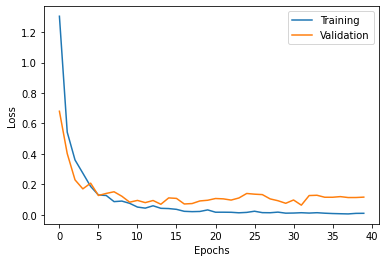

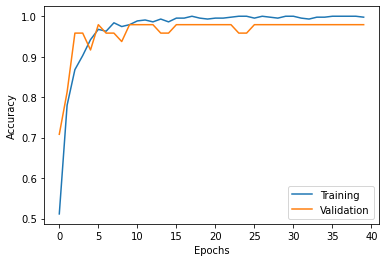

In [ ]:
# Plot training history
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

I risultati ottenuti sembrano ottimi sia in termini di loss che di accuracy, seppur leggermente peggiori rispetto a quelli ottenuti con la SVM.

In [ ]:
yc_pred = model.predict(X_test_dl)
y_pred = np.argmax(yc_pred, axis=1)

In [ ]:
print('Classification report:')
print(classification_report(y_test_dl, encoder.inverse_transform(y_pred)))

Classification report:
              precision    recall  f1-score   support

     bigmari       1.00      0.94      0.97        32
  rimbalzino       0.93      0.93      0.93        41
    stemanzo       0.90      0.94      0.92        47

    accuracy                           0.93       120
   macro avg       0.94      0.93      0.94       120
weighted avg       0.94      0.93      0.93       120



In [ ]:
model.save('audio_model.h5')

##Live Demo

In [ ]:
model = models.load_model('audio_model.h5')

In [ ]:
encoder = load(open('labelEncoder.pkl', 'rb'))

In [ ]:
duration = 5 
rec_rate = 44100

In [ ]:
def prepare_data(audio, audio_rate, mean, std, feature_extractor, normalize=False):
    feature = feature_extractor(audio, audio_rate)
    feature= np.expand_dims(feature, axis=0)
    if normalize:
        eps = 0.001
        return (feature - mean + eps)/(std + eps)
    return feature

In [ ]:
while True:
    rec = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)
    rec = rec.reshape((220500,))
    feature = prepare_data(rec, rec_rate, mean_dl, std_dl,feature_extraction_mfcc, True)
    
    yc_pred = model.predict(feature)
    print(yc_pred)
    y_pred = np.argmax(yc_pred, axis=1)
    y_pred=encoder.inverse_transform(y_pred)
    print(y_pred)